# TensorFlow Project - Traffic Signs Recognition for Autonomous Driving

## **Professor:** Dr. Tushar Das


## **Dataset Information**
- **Source:** https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
- **Link:** https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
- **Dataset information:** The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011.

- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database

<br>
<hr>
<br>

## Import Dependencies

In [ ]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from collections import Counter
from PIL import Image
from glob import glob
from sklearn.decomposition import PCA
import pandas as pd

#Phase 1: Project Pitch

1.1 Select one dataset and define the problem statement.      
1.2 Conduct exploratory data analysis (EDA).      
1.3 Decide on CNN + Transformer/LSTM/GRU approach     

### Import Dataset from Kaggle

In [ ]:
# !pip install kaggle

In [ ]:
from google.colab import files
files.upload() # Upload kaggle.json API file

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

### Define paths and configure classes in training dataset

In [ ]:
# Define paths
train_path = "/content/train"
test_path = "/content/test"

# List classes in training dataset
classes = sorted(os.listdir(train_path))
print(f"Number of classes: {len(classes)}")
print(f"Example classes: {classes[:5]}")  # Show few samples

# Count images per class
image_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in classes}
print("\nImage distribution per class (train set):")
for cls, count in list(image_counts.items())[:5]:  # Show 5 iamges
    print(f"Class {cls}: {count} images")


Number of classes: 43
Example classes: ['0', '1', '10', '11', '12']

Image distribution per class (train set):
Class 0: 210 images
Class 1: 2220 images
Class 10: 2010 images
Class 11: 1320 images
Class 12: 2100 images


### Load CSV files

In [ ]:
# Load CSV files
train_df = pd.read_csv("/content/Train.csv")
test_df = pd.read_csv("/content/Test.csv")
meta_df = pd.read_csv("/content/Meta.csv")

# Add full path to image filenames
train_df['Path'] = train_df['Path'].apply(lambda x: os.path.join('/content', x))
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join('/content', x))

# Display first few rows
print("\nTrain.csv:")
display(train_df.head())

print("\nTest.csv:")
display(test_df.head())

print("\nMeta.csv:")
display(meta_df.head())



Train.csv:


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,/content/Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,/content/Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,/content/Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,/content/Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,/content/Train/20/00020_00000_00004.png



Test.csv:


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,/content/Test/00000.png
1,42,45,5,5,36,40,1,/content/Test/00001.png
2,48,52,6,6,43,47,38,/content/Test/00002.png
3,27,29,5,5,22,24,33,/content/Test/00003.png
4,60,57,5,5,55,52,11,/content/Test/00004.png



Meta.csv:


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


### Display random images

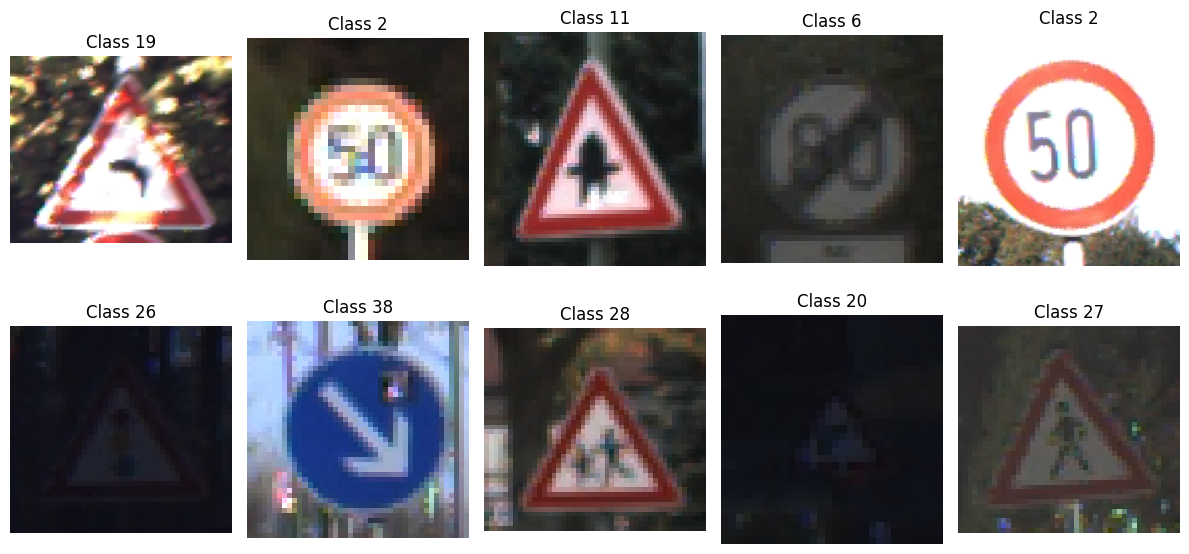

In [ ]:
def show_random_images(dataset_path, num_images=10):
    """
    Displays a specified number of random images from the dataset.

    Args:
        dataset_path (str): Path to the dataset containing images organized by class.
        num_images (int, optional): Number of random images to display. Default is 10.

    Returns:
        None: Displays a grid of random images from the dataset.
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for ax in axes:
        class_name = random.choice(os.listdir(dataset_path))
        img_path = os.path.join(dataset_path, class_name, random.choice(os.listdir(os.path.join(dataset_path, class_name))))
        img = Image.open(img_path)

        ax.imshow(img)
        ax.set_title(f"Class {class_name}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(train_path)


### Compare two random images from different classes

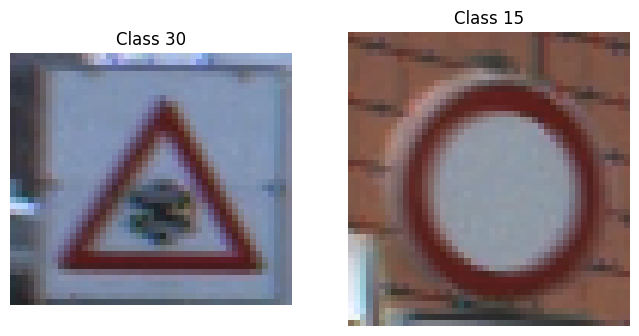

In [ ]:
import cv2

# Compare two random images from different classes
def compare_two_random_images(dataset_path):
    """
    Compares two random images from different classes in the dataset.

    Args:
        dataset_path (str): Path to the dataset with images organized into subdirectories by class.

    Returns:
        None: Displays a side-by-side comparison of two random images from different classes.
    """
    class_names = random.sample(os.listdir(dataset_path), 2)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for i, class_name in enumerate(class_names):
        img_path = os.path.join(dataset_path, class_name, random.choice(os.listdir(os.path.join(dataset_path, class_name))))
        img = cv2.imread(img_path)  # Read as BGR * https://www.geeksforgeeks.org/convert-bgr-and-rgb-with-python-opencv/
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        axes[i].imshow(img)
        axes[i].set_title(f"Class {class_name}")
        axes[i].axis("off")

    plt.show()


# Compare two images
compare_two_random_images(train_path)

### Get image dimensions

In [ ]:
from PIL import Image
import numpy as np

# Get images dimensions
def get_image_sizes(dataset_path):
    """
    Retrieves the dimensions (width, height) of all images in the dataset.

    Args:
        dataset_path (str): Path to the dataset with images in class subdirectories.

    Returns:
        np.ndarray: Array of image dimensions (width, height) for each image.
    """
    image_sizes = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            image_sizes.append(img.size)  # (width, height)

    return np.array(image_sizes)

# Get image sizes from the train set
image_sizes = get_image_sizes(train_path)

# Print summary
print(f"Average size: {image_sizes.mean(axis=0)}")
print(f"Min size: {image_sizes.min(axis=0)}, Max size: {image_sizes.max(axis=0)}")


Average size: [50.83587952 50.32892958]
Min size: [25 25], Max size: [243 225]


### Class Distribution
Check the class distribution in the training set.

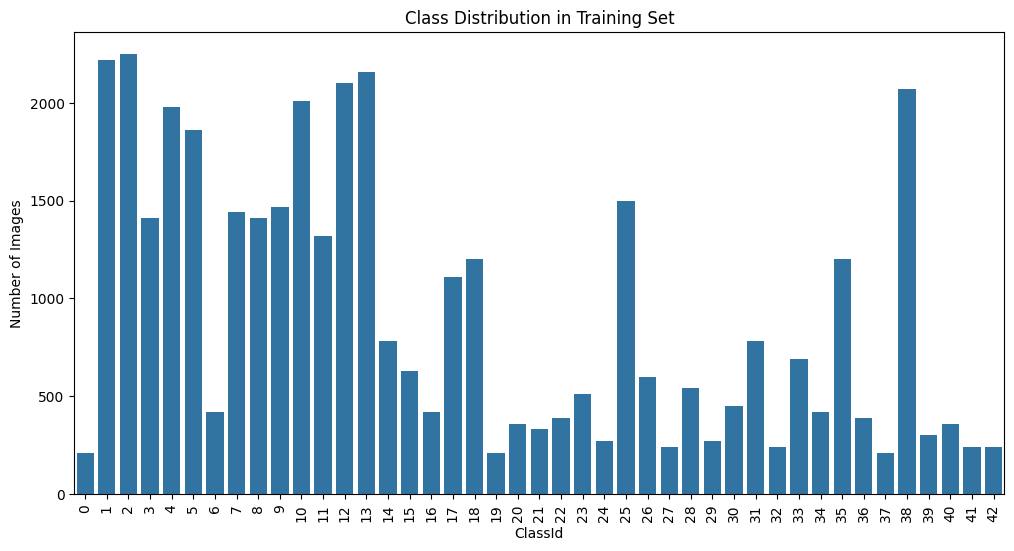

In [ ]:
# Convert class distribution to a DataFrame
train_counts = train_df['ClassId'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.show()

In [ ]:
print(f"Class with the fewest images: {min(image_counts, key=image_counts.get)} - {min(image_counts.values())} images")
print(f"Class with the most images: {max(image_counts, key=image_counts.get)} - {max(image_counts.values())} images")

Class with the fewest images: 0 - 210 images
Class with the most images: 2 - 2250 images


### Check if there are any corrupted images

In [ ]:
def check_corrupted_images(dataset_path):
    """
    Checks for corrupted imagens in the dataset by verifyign each image file.
    Returns a list of paths to corrupted images.

    Args:
        dataset_path (str): Path to the dataset with images organized by class.

    Retrurns:
        list: Paths to corrupted image files.

    Example:
        corrupted_images = check_corrupted_images('/path/to/dataset')
    """
    corrupted = []

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path)
                img.verify()  # Check for corrutpion
            except:
                corrupted.append(img_path)

    return corrupted

# Find corrupted images
corrupted_images = check_corrupted_images(train_path)

if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images.")
    print("Example:", corrupted_images[:5])
else:
    print("No corrupted images found.")

No corrupted images found.


### Flatten images and apply PCA

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(dataset_path, num_samples=100):
    """
    Applies PCA to reduce image data to 2D for visualization, coloring the points by class labels.

    Args:
        dataset_path (str): Path to the dataset with images in class subdirectories.
        num_samples (int, optional): Number of images to sample from each class. Default is 100.

    Returns:
        None: Displays a 2D scater plot of the PCA projection.
    """
    image_data = []
    labels = []

    # Iterate trhough each class in the dataseet
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        # Check if the path is a directory
        if os.path.isdir(class_path):
            # Get the images in the class folder
            class_images = os.listdir(class_path)
            num_samples_in_class = min(num_samples, len(class_images))

            # Sample images from the class
            for img_file in random.sample(class_images, num_samples_in_class):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path).resize((32, 32))  # Resize to standard size
                img_array = np.array(img).flatten()  # Flatten image to 1D
                image_data.append(img_array)
                labels.append(class_name)

    image_data = np.array(image_data)

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform


### t-SNE Visualization:
For a more sophisticated view of class separation, we also use t-SNE (a non-linear alternative to PCA).

<ipython-input-13-11e2789b0223>:35: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels_encoded, _ = pd.factorize(labels)


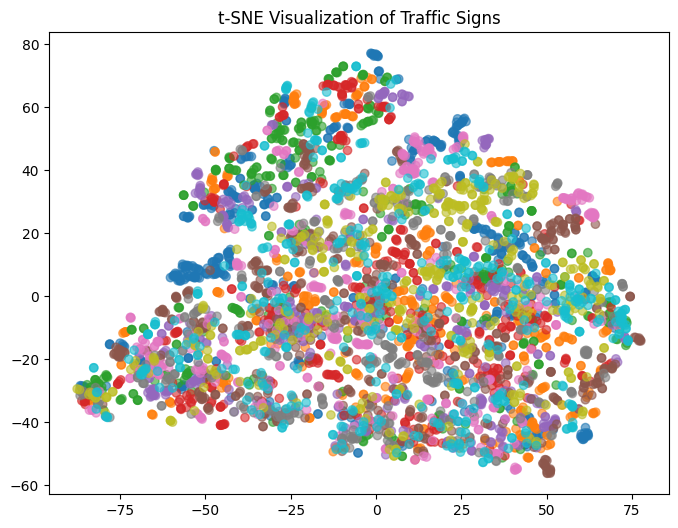

In [ ]:
from sklearn.manifold import TSNE

def apply_tsne(dataset_path, num_samples=100):
    """
    Visualizes image data distribution in 2D using t-SNE.

    Randomly selects `num_samples` images from each class, flattens them,
    and applies t-SNE to reduce the dimensionality to 2D. It then plots the
    images in 2D space, colored by their class labels.

    Args:
        dataset_path (str): Path to the dataset with images organized by class.
        num_samples (int, optional): Number of random samples to take from each class. Default is 100.

    Returns:
        None: Displays a scatter plot of the 2D t-SNE projection, colored by class.
    """
    image_data = []
    labels = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_images = os.listdir(class_path)
            for img_file in random.sample(class_images, min(num_samples, len(class_images))):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path).resize((32, 32))
                img_array = np.array(img).flatten()
                image_data.append(img_array)
                labels.append(class_name)

    image_data = np.array(image_data)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(image_data)

    labels_encoded, _ = pd.factorize(labels)
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels_encoded, cmap="tab10", alpha=0.6)
    plt.title("t-SNE Visualization of Traffic Signs")
    plt.show()

apply_tsne(train_path)


### Image size distribution in metadata
The files contain columns such as Width and Height, where we can calculate statistics (`mean, median, minimum, maximum`) and visualize the distribution.

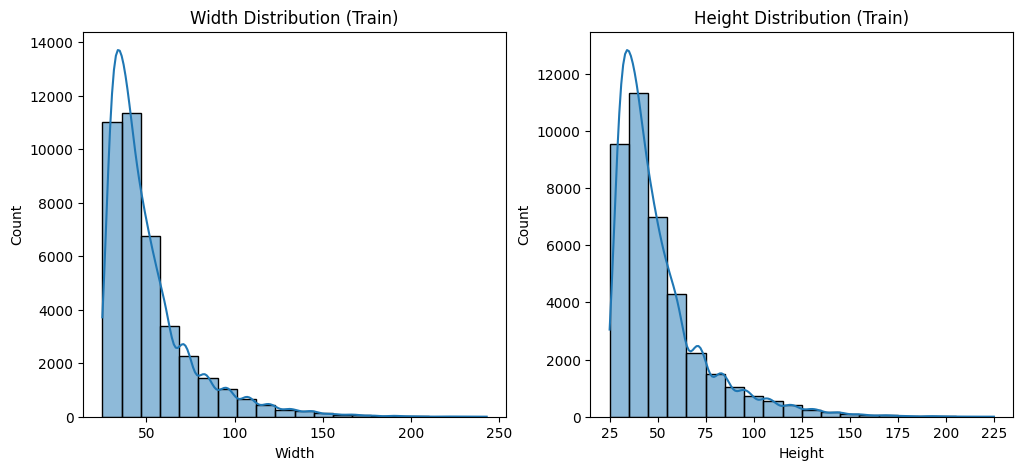

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['Width'], bins=20, kde=True)
plt.title("Width Distribution (Train)")
plt.subplot(1, 2, 2)
sns.histplot(train_df['Height'], bins=20, kde=True)
plt.title("Height Distribution (Train)")
plt.show()

### Image Quality Analysis
**Brightness and Contrast:** Calculate brightness statistics (`mean intensity`) and contrast (`standard deviation of intensity`) to check for variations in capture conditions.

Average Brightness: 81.53, Average Contrast: 42.07


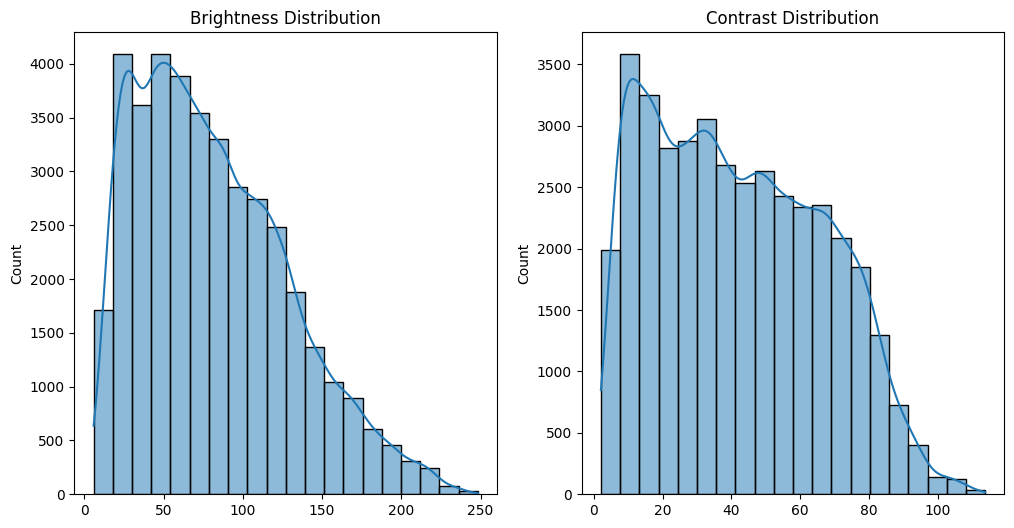

In [ ]:
def analyze_brightness_contrast(dataset_path):
    """
    Analyzes brightness and contrast of images in the dataset.

    Computes the average brightness and contrast, then displays histograms
    showing their distributions across the dataset.

    Args:
        dataset_path (str): Path to the dataset with images organized by class.

    Returns:
        None: Prints average brightness and contrast, and shows histograms.
    """
    brightness = []
    contrast = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file), cv2.IMREAD_GRAYSCALE)
            brightness.append(np.mean(img))
            contrast.append(np.std(img))

    print(f"Average Brightness: {np.mean(brightness):.2f}, Average Contrast: {np.mean(contrast):.2f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(brightness, bins=20, kde=True)
    plt.title("Brightness Distribution")
    plt.subplot(1, 2, 2)
    sns.histplot(contrast, bins=20, kde=True)
    plt.title("Contrast Distribution")
    plt.show()

analyze_brightness_contrast(train_path)

### Correlation between variables
Check for correlations between numerical columns (such as `Width, Height, Roi.X1, Roi.Y1, etc.`) using a `correlation matrix`.

**ROI (`Region of Interest) Analysis:** The columns `Roi.X1, Roi.Y1, Roi.X2, and Roi.Y2` define the bounding boxes of traffic signs. It's possible calculate the ROI size (`area = (Roi.X2 - Roi.X1) * (Roi.Y2 - Roi.Y1)`) and analyze its `distribution` by `class`.

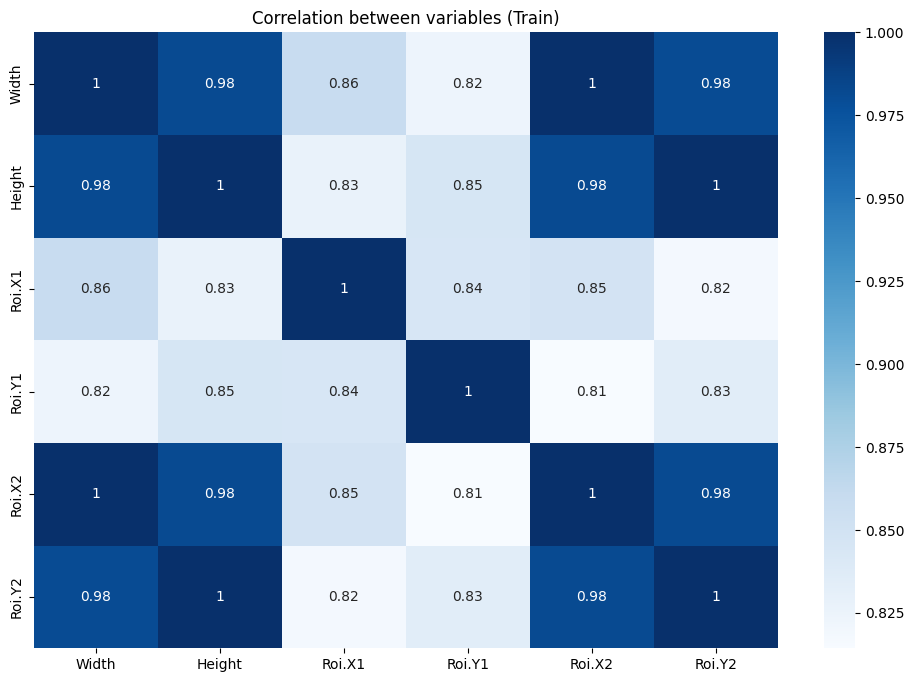

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df[['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']].corr(), annot=True, cmap="Blues")
plt.title("Correlation between variables (Train)")
plt.show()

### Color and Intensity Analysis
Since the images are of traffic signs, pixel colors and intensity can be informative:

**RGB Channel Distribution:** Select a few random images and analyze the distribution of `RGB channel` values to understand the dominant colors in the dataset.


References:
- https://docs.opencv.org/4.x/index.html
- https://www.geeksforgeeks.org/python-opencv-cv2-cvtcolor-method/
- https://wavesofvoqueric.com/software/2020/03/31/19/29/opencv-image-to-tensorflow-tensor/

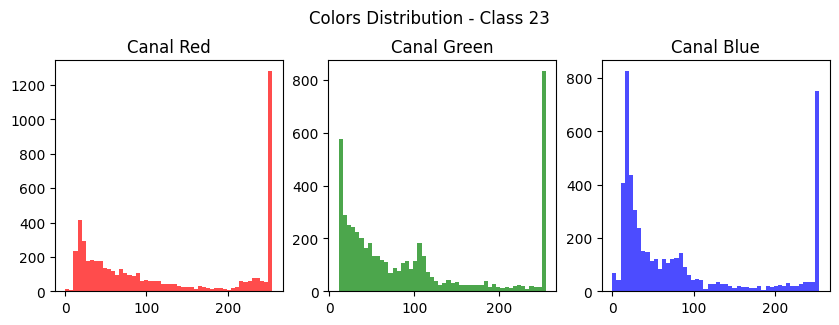

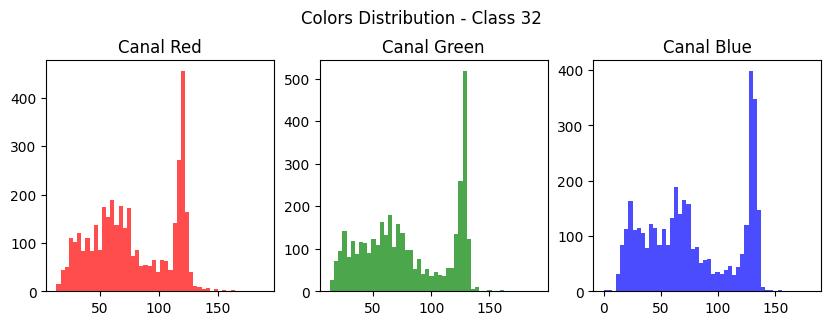

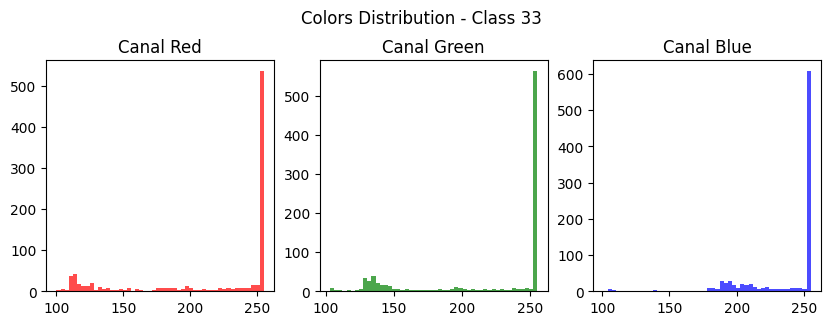

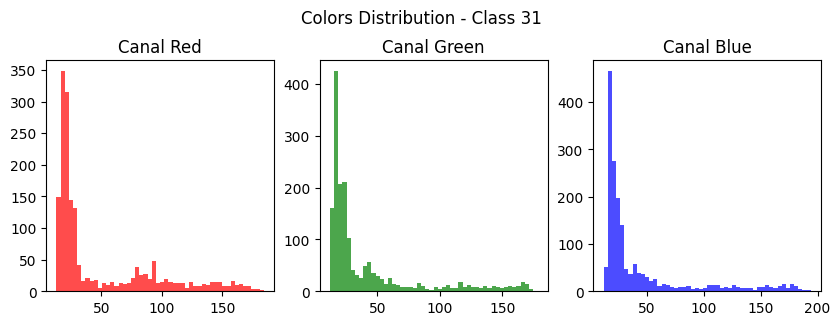

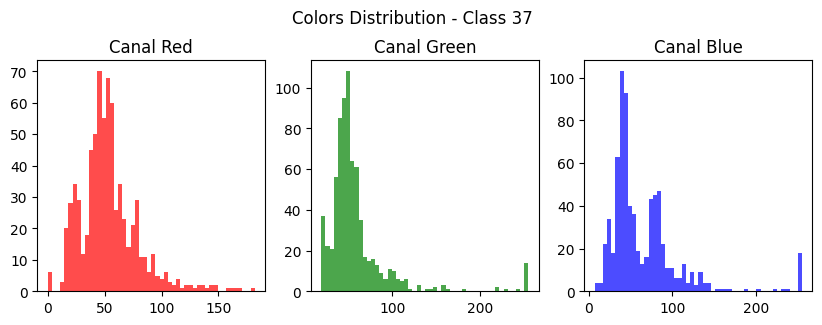

In [ ]:
def analyze_color_distribution(dataset_path, num_samples=5):
    """
    Analyzes and visualizes color distribution (RGB channels) of random samples.

    Randomly selects `num_samples` images, computes color histograms for
    the red, green, and blue channels, and displays them.

    Args:
        dataset_path (str): Path to the dataset with images organized by class.
        num_samples (int, optional): Number of samples to analyze. Default is 5.

    Returns:
        None: Displays histograms for the color distribution of each sample.
    """
    for i in range(num_samples):
        class_name = random.choice(os.listdir(dataset_path))
        img_path = os.path.join(dataset_path, class_name, random.choice(os.listdir(os.path.join(dataset_path, class_name))))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 3))
        for j, color in enumerate(['Reds', 'Greens', 'Blues']):
            plt.subplot(1, 3, j+1)
            plt.hist(img[:, :, j].ravel(), bins=50, color=color.split('s')[0].lower(), alpha=0.7)
            plt.title(f"Canal {color.split('s')[0]}")
        plt.suptitle(f"Colors Distribution - Class {class_name}", y=1.05)
        plt.show()

analyze_color_distribution(train_path)

**Mean and Standard Deviation per Channel:**      
Calculate the `mean` and `standard deviation` of `RGB` values for the training set.

References:
- https://www.geeksforgeeks.org/standard-deviation-across-the-image-channels-in-pytorch/

In [ ]:
def compute_channel_stats(dataset_path):
    """
    Computes and prints the mean and standard deviation of pixel values
    for each color channel (Red, Green, Blue) in a dataset.

    Args:
        dataset_path (str): Path to the dataset with images organized by class.

    Returns:
        None: Prints the mean and standard deviation for each color channel.
    """
    r, g, b = [], [], []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            r.append(np.mean(img[:, :, 0]))
            g.append(np.mean(img[:, :, 1]))
            b.append(np.mean(img[:, :, 2]))

    print(f"R: Mean = {np.mean(r):.2f}, Standard Deviation = {np.std(r):.2f}")
    print(f"G: Mean = {np.mean(g):.2f}, Standard Deviation = {np.std(g):.2f}")
    print(f"B: Mean = {np.mean(b):.2f}, Standard Deviation = {np.std(b):.2f}")

compute_channel_stats(train_path)


R: Mean = 86.76, Standard Deviation = 50.67
G: Mean = 79.59, Standard Deviation = 46.95
B: Mean = 81.96, Standard Deviation = 46.88


#Phase 2: Mid-Level Assessment
2.1 Data Preprocessing & Feature Engineering.      
2.2 Model implementation

### Data Preprocessing & Feature Engineering.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import os

#### Preprocess images

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """Loads and preprocesses an image for the model.
    Args:
        image_path (str): Path to the image.
        target_size (tuple): Target size (height, width).
    Returns:
        np.ndarray: Processed image with values in [0, 1].
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, target_size)          # Resize to 32x32
        img = img / 255.0                           # Normalize to [0, 1]
        return img
    except FileNotFoundError as e:
        print(f"Error loading image: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading image: {e}")
        return None

#### Load and prepare data

In [ ]:
def load_data(df, target_size=(32, 32)):
    """
    Loads images and labels into NumPy arrays.
    Args:
        df (pandas.DataFrame): DataFrame with image paths and class IDs.
        target_size (tuple): Size to resize images.
    Returns:
        tuple: (images, labels) as NumPy arrays.
    """
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = row['Path']
        img = load_and_preprocess_image(img_path, target_size)
        if img is not None:
            images.append(img)
            labels.append(row['ClassId'])

    return np.array(images), np.array(labels)

### Data Preparation and Splitting for Model Training
Prepares and splits the dataset for training. It loads the data, splits it into `training (80%)` and `validation (20%)` sets, and converts labels into `one-hot encoding` for classification. Finally, it prints the shapes of the datasets to confirm everything is set up correctly.

In [ ]:
from tensorflow.keras.utils import to_categorical

# Define number of classes
num_classes = train_df['ClassId'].nunique()
print(f"Number of classes: {num_classes}")

# Split training data into training and validation sets
train_df_split, val_df = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['ClassId'])

# Load training, validation, and test data
X_train, y_train = load_data(train_df_split, target_size=(32, 32))
X_val, y_val = load_data(val_df, target_size=(32, 32))
X_test, y_test = load_data(test_df, target_size=(32, 32))

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Check data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Number of classes: 43
X_train shape: (31367, 32, 32, 3), y_train shape: (31367, 43)
X_val shape: (7842, 32, 32, 3), y_val shape: (7842, 43)
X_test shape: (12630, 32, 32, 3), y_test shape: (12630, 43)


### Data Augmentation and Visualization for Training Images     
Applies data augmentation to training images using `ImageDataGenerator`. It randomly rotates, shifts, and zooms images to make the model more robust.
It also includes a function, `visualize_augmentation()`, which shows a batch of augmented images to verify the transformations. Finally, it applies the `augmentation` to `X_train` and displays the modified images.

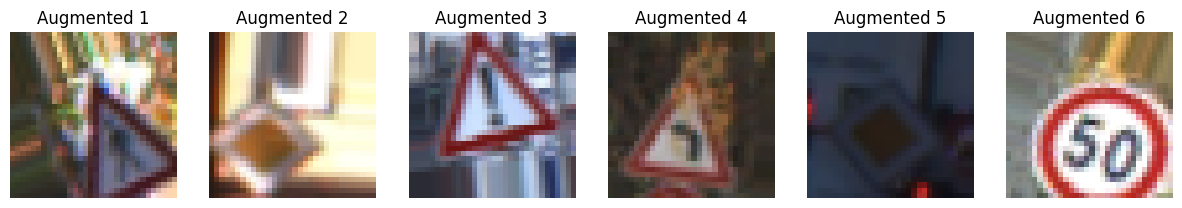

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,        # Rotation up to 30 degrees
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    zoom_range=0.1,           # Zoom up to 10%
    fill_mode='nearest'       # Fill empty areas with the nearest pixel
)

# Function to visualize augmented images
def visualize_augmentation(datagen, X_train, num_images=6):
    """
    Visualizes a batch of augmented images.

    Args:
        datagen (ImageDataGenerator): Data generator for augmentations.
        X_train (numpy.ndarray): Training data to augment.
        num_images (int): Number of images to display (default is 6).

    Returns:
        None: Displays the augmented images in a grid.
    """
    aug_iterator = datagen.flow(X_train, batch_size=num_images, shuffle=True)
    aug_images = next(aug_iterator)

    plt.figure(figsize=(2.5 * num_images, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = np.clip(aug_images[i], 0, 1)
        plt.imshow(img)
        plt.title(f"Augmented {i+1}")
        plt.axis('off')
    plt.show()


# Apply augmentation on X_train
datagen.fit(X_train)

# Visualize images
visualize_augmentation(datagen, X_train)

### Model Development    
Builds, trains, and evaluates a `CNN model` for image classification. It defines a Sequential model with three `convolutional layers`, `batch normalization`, and `max pooling`. After `flattening`, it includes `fully connected layers` with `dropout` to reduce overfitting.

The model is compiled with `Adam optimizer` and `categorical cross-entropy` loss. It’s trained using data augmentation for `20 epochs` and then evaluated on the test set. Finally, it plots `accuracy` and `loss curves` to visualize training progress.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,523 (923.92 KB)

 Trainable params: 236,075 (922.17 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.2164 - loss: 3.0162 - val_accuracy: 0.6613 - val_loss: 1.0271
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6009 - loss: 1.2481 - val_accuracy: 0.8757 - val_loss: 0.3828
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.7824 - loss: 0.6764 - val_accuracy: 0.9528 - val_loss: 0.1476
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8475 - loss: 0.4755 - val_accuracy: 0.9441 - val_loss: 0.1670
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8770 - loss: 0.3904 - val_accuracy: 0.9776 - val_loss: 0.0756
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9048 - loss: 0.3153 - val_accuracy: 0.9773 - val_loss: 0.0715
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9141 - loss: 0.2760 - val_accuracy: 0.9770 - val_loss: 0.0678
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9280 - loss: 0.2308 - val_accurac

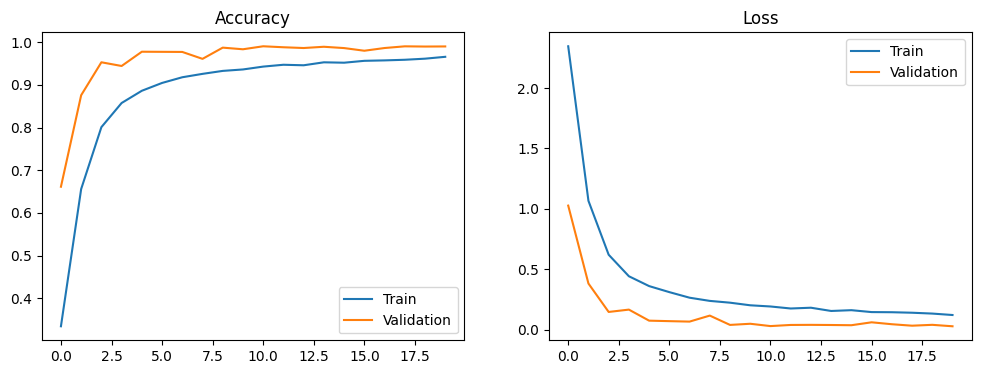

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),  # Normalization to stabilize training
    MaxPooling2D((2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten to dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model with data augmentation
batch_size = 32
epochs = 20

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs,
    verbose=1
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

### Model Evaluation and Training Performance Visualization

Evaluates the model on the test set and visualizes training performance using accuracy and loss plots.

**Two subplots are created:**
- **Accuracy plot:** Shows training and validation accuracy per epoch, highlighting the best validation accuracy.
- **Loss plot:** Displays training and validation loss per epoch, marking the lowest validation loss.

`Annotations` and `dashed lines` indicate the best results.

Test accuracy: 0.9549, Test loss: 0.2098


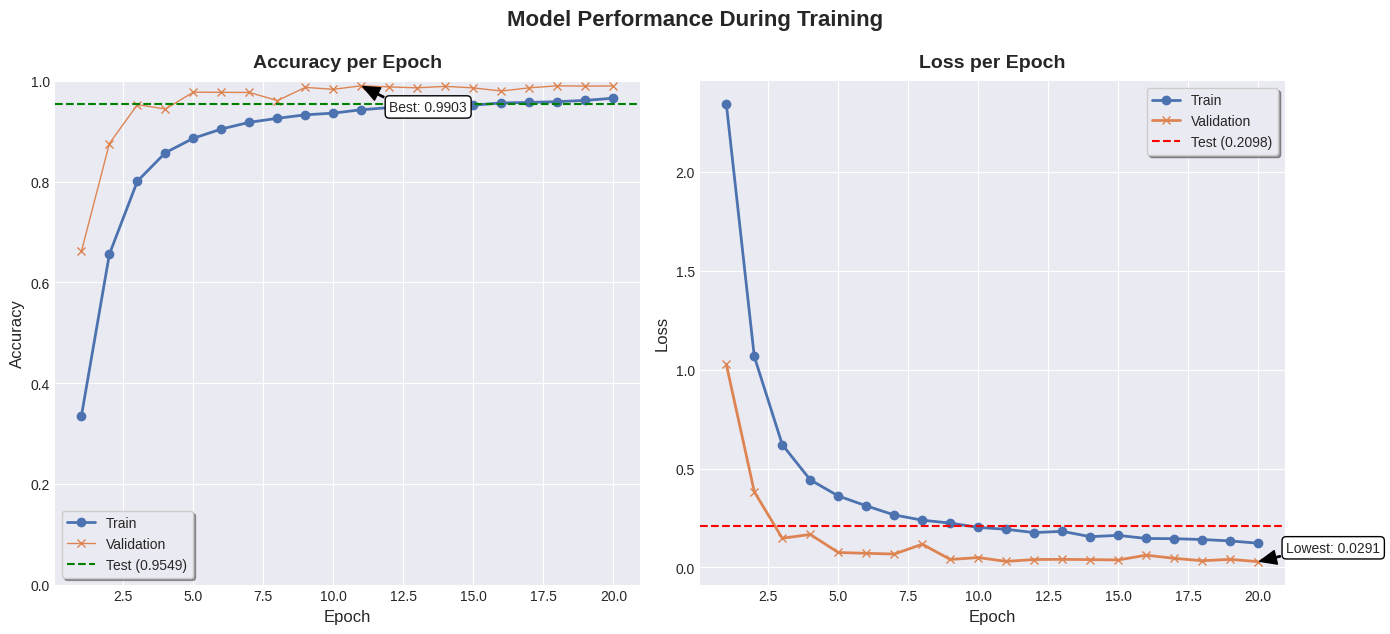

In [ ]:
import seaborn as sns

# Check how the model does on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

# Set up a nice look
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")

# Create a figure with a good size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Accuracy plot
epochs = range(1, len(history.history['accuracy']) + 1)
ax1.plot(epochs, history.history['accuracy'], 'o-', label='Train', linewidth=2, markersize=6)
ax1.plot(epochs, history.history['val_accuracy'], 'x-', label='Validation', linewidth=1, markersize=6)
ax1.axhline(y=test_accuracy, color='green', linestyle='--', linewidth=1.5, label=f'Test ({test_accuracy:.4f})')
ax1.set_title('Accuracy per Epoch', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='best', fontsize=10, frameon=True, shadow=True)
ax1.set_ylim(0, 1)
ax1.tick_params(axis='both', labelsize=10)

# Point out the best validation accuracy
best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1  # Find the epoch with the highest validation accuracy
best_val_acc = max(history.history['val_accuracy'])  # Get that highest value
ax1.annotate(f'Best: {best_val_acc:.4f}',
             xy=(best_val_acc_epoch, best_val_acc),
             xytext=(best_val_acc_epoch + 1, best_val_acc - 0.05),  # Place bit offset
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=10),  # Add a small arrow
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Loss plot
ax2.plot(epochs, history.history['loss'], 'o-', label='Train', linewidth=2, markersize=6)  # training loss with circles
ax2.plot(epochs, history.history['val_loss'], 'x-', label='Validation', linewidth=2, markersize=6)  # validation loss with x
ax2.axhline(y=test_loss, color='red', linestyle='--', linewidth=1.5, label=f'Test ({test_loss:.4f})')  # dashed line for test loss
ax2.set_title('Loss per Epoch', fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='best', fontsize=10, frameon=True, shadow=True)
ax2.tick_params(axis='both', labelsize=10)

# Point out the lowest validation loss
best_val_loss_epoch = np.argmin(history.history['val_loss']) + 1  # Find the epoch with the lowest validation loss
best_val_loss = min(history.history['val_loss'])  # Get that lowest value
ax2.annotate(f'Lowest: {best_val_loss:.4f}',
             xy=(best_val_loss_epoch, best_val_loss),
             xytext=(best_val_loss_epoch + 1, best_val_loss + 0.05),  # Place bit offset
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=10),  # Add a small arrow
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.tight_layout()
fig.suptitle('Model Performance During Training', fontsize=16, fontweight='bold', y=1.05)
plt.show()

Evaluates the model's performance on the test set. It first computes the `test loss` and `accuracy`, then generates predictions. The predicted and actual labels are converted from `one-hot encoding` to `class indices`. Finally, it prints a `classification report`, showing `precision`, `recall`, and `F1-score` for each class.

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Check how the model does on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

# Get predictions from the model
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_indices, y_pred_indices))

Test accuracy: 0.9549, Test loss: 0.2098
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        60
           1       0.97      0.99      0.98       720
           2       0.99      0.98      0.98       750
           3       0.90      0.96      0.93       450
           4       0.99      0.96      0.97       660
           5       0.95      0.95      0.95       630
           6       0.99      1.00      1.00       150
           7       0.99      0.91      0.95       450
           8       0.91      0.98      0.94       450
           9       0.99      0.99      0.99       480
          10       1.00      0.99      0.99       660
          11       0.90      0.97      0.94       420
          12       0.97      0.96      0.96       690
          13       0.97      1.00      0.98       720
          14       1.00      1.00      1.00       270
          15       1.00      

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


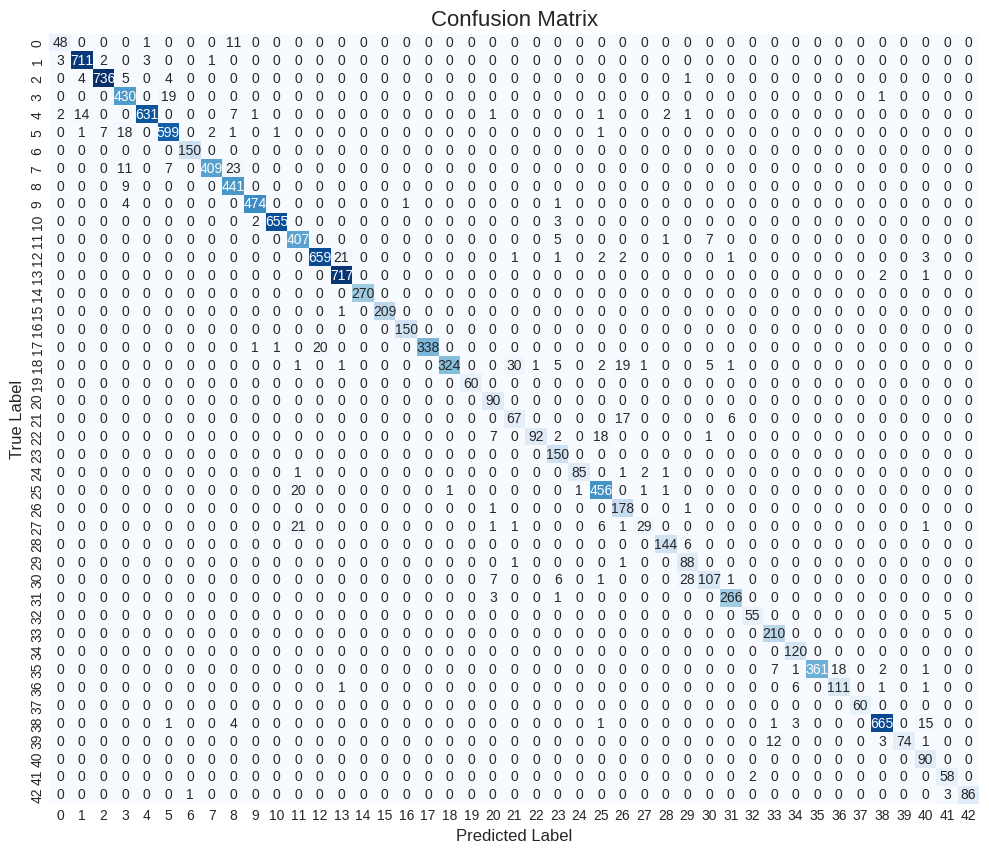

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_indices, y_pred_indices)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


### Model Predictions vs True Labels
Visualizes model predictions by displaying 10 random test images along with their `true` and `predicted labels`.

It first tries to load class names from `Meta.csv`, if its unavialable, it uses class indices. Then, selects 10 random test images and sets up a plot grid. Each image is displayed with its predicted label (`green if correct` and `red if incorrect`) and true label.

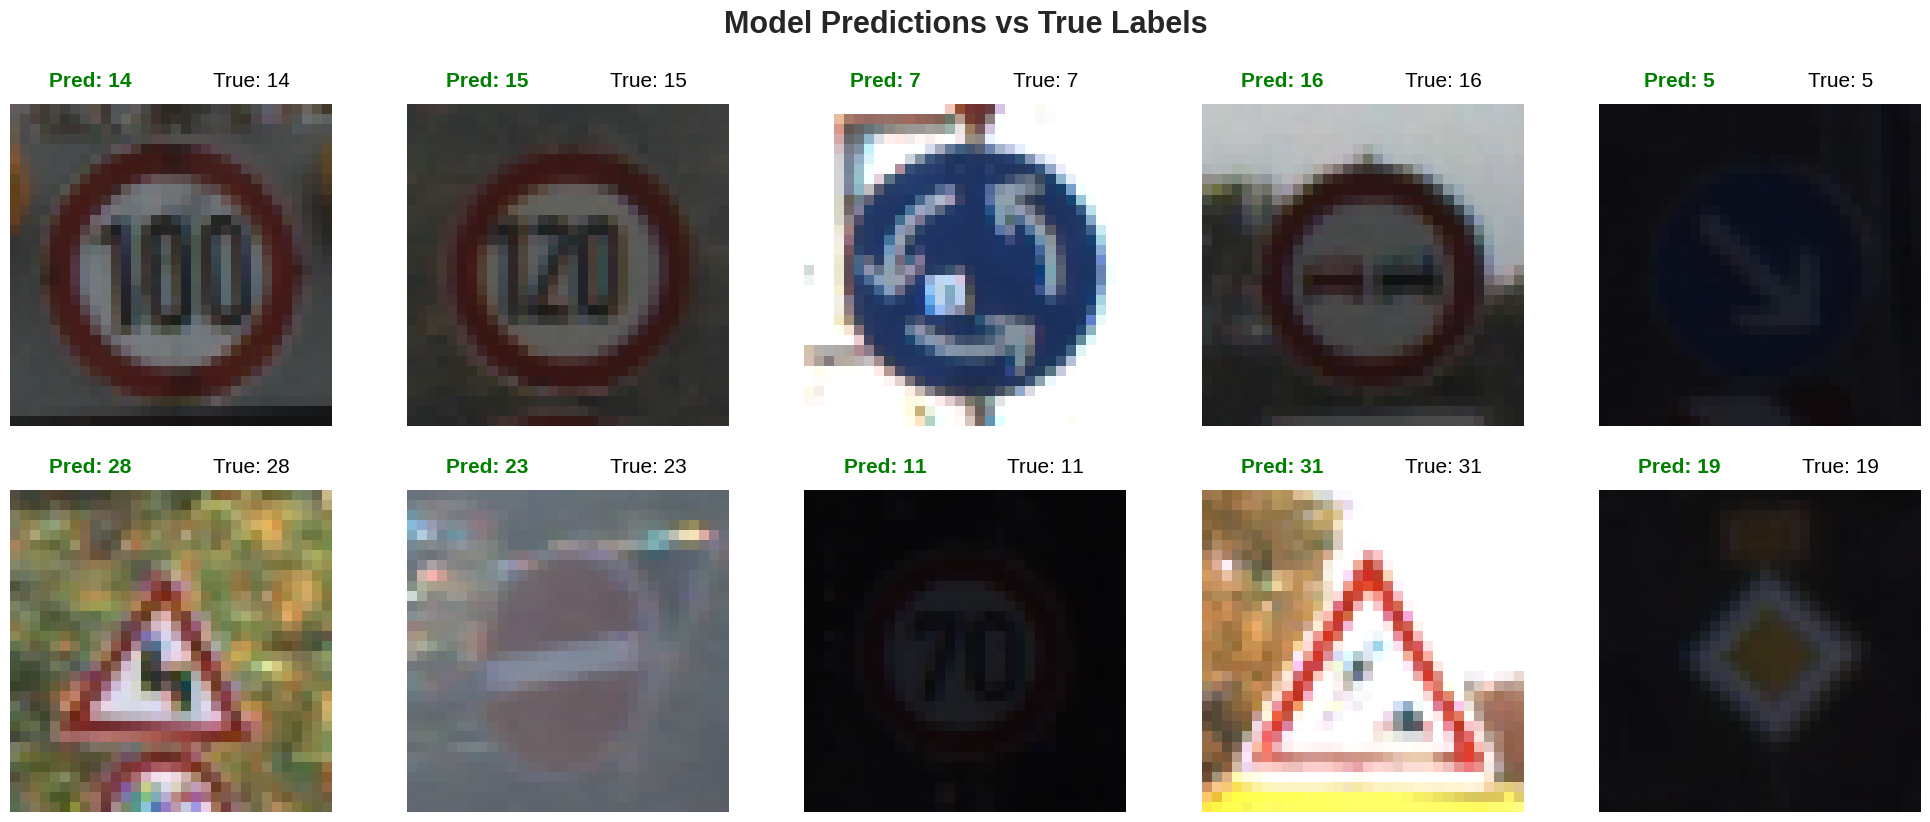

In [ ]:
# Try to load class names from Meta.csv, use indices if it fails
try:
    meta_df = pd.read_csv("/content/Meta.csv")
    class_names = meta_df['ClassId'].astype(str).values
except (FileNotFoundError, KeyError):
    class_names = None
    print("Could’t load class names from Meta.csv. Using class indices instead.")

# Pick 10 random imagens from the test set
num_images = 10
random_indices = np.random.choice(len(X_test), num_images, replace=False)
selected_images = X_test[random_indices]
selected_y_true = y_test_indices[random_indices]
selected_y_pred = y_pred_indices[random_indices]

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=100)
axes = axes.flatten()

# Loop through the selected images and plot them
for i, (img, y_true, y_pred) in enumerate(zip(selected_images, selected_y_true, selected_y_pred)):
    ax = axes[i]

    ax.imshow(np.clip(img, 0, 1))  # Make sure pixel values between 0 and 1
    ax.axis('off')

    # Check the prediction
    is_correct = y_pred == y_true
    pred_color = 'green' if is_correct else 'red'

    # Setup labels depending on whether we have class names
    if class_names is not None and len(class_names) > max(y_pred, y_true):
        pred_label = f"Pred: {class_names[y_pred]}"
        true_label = f"True: {class_names[y_true]}"
    else:
        pred_label = f"Pred: {y_pred}"
        true_label = f"True: {y_true}"

    # Add prediction text on the left side
    ax.text(0.25, 1.1, pred_label, transform=ax.transAxes, fontsize=15,
            color=pred_color, ha='center', va='top', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2))

    # Add true label on the right side
    ax.text(0.75, 1.1, true_label, transform=ax.transAxes, fontsize=15,
            color='black', ha='center', va='top',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2))

fig.suptitle('Model Predictions vs True Labels', fontsize=22, fontweight='bold', y=1.02)
plt.tight_layout(pad=1.0)
plt.subplots_adjust(hspace=0.2)
plt.show()

<hr>